#Mount DS4A2 as main folder to work from colab
1 - Setup the google drive for using in colab


In [1]:
from google.colab import drive  

In [2]:
drive.mount('/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
%cd /gdrive/My\ Drive/DS4A2 

/gdrive/.shortcut-targets-by-id/15cQeEe0owbmNusdu1b0EqARkzJa2JVvV/DS4A2


In [2]:
%cd /gdrive/.shortcut-targets-by-id/15cQeEe0owbmNusdu1b0EqARkzJa2JVvV/DS4A2/Team/Santiago

/gdrive/.shortcut-targets-by-id/15cQeEe0owbmNusdu1b0EqARkzJa2JVvV/DS4A2/Team/Santiago


#Working with the PB cell dataset


1 - Main packages

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn.model_selection import train_test_split


# Basic imports and commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
#torch.cuda.set_device(2)

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

#sns.set_style("darkgrid")
from efficientnet_pytorch import EfficientNet


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(42)

2 - Read the dataset from the path as dataframe

In [3]:

# path = "./Dataset/PBC_dataset_normal_DIB/" # path Colab
path = "../data/"

In [4]:
train=pd.read_csv(path + "train.csv", index_col=0)
train.reset_index(inplace=True, drop=True)
train.head()

,Nombre,Tipo,Subtipo,Ruta
0,ig_MMY_303957,ig,MMY,ig/MMY_303957.jpg
1,ig_PMY_39029,ig,PMY,ig/PMY_39029.jpg
2,neutrophil_SNE_209710,neutrophil,SNE,neutrophil/SNE_209710.jpg
3,neutrophil_BNE_348065,neutrophil,BNE,neutrophil/BNE_348065.jpg
4,neutrophil_BNE_727973,neutrophil,BNE,neutrophil/BNE_727973.jpg


3 - Proportions of cell types in a pie chart

In [5]:
train['Tipo'].value_counts()

neutrophil      2680
eosinophil      2497
ig              2297
platelet        1884
erythroblast    1242
monocyte        1134
basophil         981
lymphocyte       958
Name: Tipo, dtype: int64

In [6]:
bs = 32 # batch size
tfms = get_transforms(flip_vert=True, max_warp=None, max_zoom=1.01, max_rotate=120, max_lighting=0.1)
data = (ImageList.from_df(train, path=path, cols='Ruta')
       .split_by_rand_pct(valid_pct=0.15, seed=42)
       .label_from_df(cols='Tipo')
       .transform(tfms, size=224)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

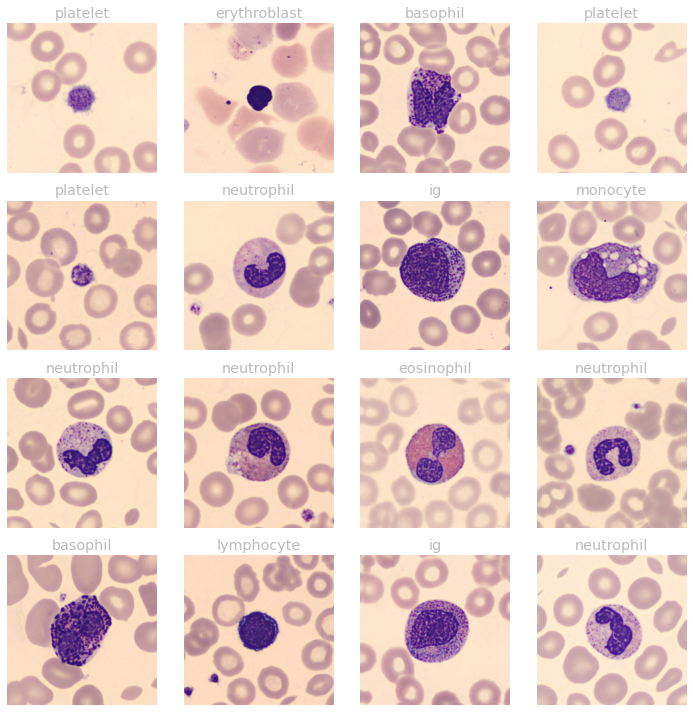

In [7]:
data.show_batch(rows=4, figsize=(10,10))

In [8]:
md_ef = EfficientNet.from_pretrained('efficientnet-b4')
md_ef

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /home/santi/.cache/torch/checkpoints/efficientnet-b4-6ed6700e.pth
100.0%


Loaded pretrained weights for efficientnet-b4


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [12]:
md_ef._fc = nn.Linear(1792, data.c)
learn = Learner(data, md_ef, metrics = [error_rate])
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (11623 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ig,ig,neutrophil,neutrophil,neutrophil
Path: ../data;

Valid: LabelList (2050 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
neutrophil,platelet,eosinophil,ig,eosinophil
Path: ../data;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), v

In [13]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.284901,57.724785,0.296585,01:56
1,0.063703,0.028672,0.011220,01:56


In [14]:
learn.save('stage1_effB4')

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


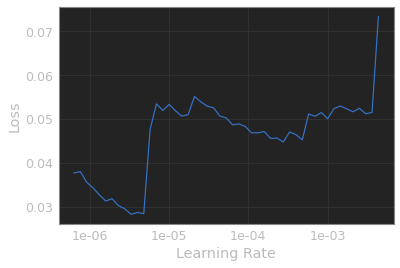

In [17]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(2, max_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.148825,0.128387,0.042927,01:56
1,0.054957,0.027648,0.008293,01:56


In [20]:
learn.save('stage2_effB4')

In [26]:
learn.export('model_effB4.pkl')